# Label Differences
In this notebook I hope to quantify the differences between teams and create some suitable labels.  i.e. how much of a winning percentage advantage do you have?  .100 or .001?

The average difference in run delta percent is 0.007  
The average streak delta is 0.3
The average RS delta is -0.07
The average RA delta is 0.42
The average run delta delta is -0.5

I think this may be unnecessary work... (4/5)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from numpy import interp
from sklearn.model_selection import cross_val_score

In [25]:
df = pd.read_csv("2019_all_delta_extra.csv")

In [42]:
df[100:200]

,Date,Home_Win,Home,Away,Win Percent Delta,Streak Delta,Run Scored Delta,Run Allowed Delta,Run Delta Delta,Run Delta Percent Delta,Win Total Delta
100,sunday jul 21,L,SEA,LAA,-0.113960,-2,-11,101,-112,-0.1887,-11
101,tuesday jul 23,L,LAD,LAA,0.142011,1,37,-113,150,0.3912,15
102,wednesday jul 24,L,LAD,LAA,0.130878,-4,36,-112,148,0.3817,14
103,thursday jul 25,L,LAA,BAL,0.207440,5,98,-104,202,0.3341,22
104,friday jul 26,L,LAA,BAL,0.195701,-2,96,-102,198,0.3225,21
...,...,...,...,...,...,...,...,...,...,...,...
195,tuesday may 7,L,HOU,KCR,0.266667,5,9,-52,61,0.4439,9
196,wednesday may 8,W,HOU,KCR,0.231982,-2,-1,-42,41,0.2859,8
197,thursday may 9,W,HOU,TEX,0.094595,0,-14,-42,28,0.2295,5
198,friday may 10,W,HOU,TEX,0.119549,3,-12,-44,32,0.2518,6


In [4]:
X = df.loc[:,df.columns[4:]]
df_bool = (X >= 0)
X_bool = df_bool.values
y = df.loc[:,df.columns[1]].values

In [22]:
WPD = df.loc[:,df.columns[4]].values
WPD.std()

0.17941346874752329

In [63]:
#sigma dictionary, set the values you want for items falling in certain stanard deviations
encoding_dict = {-4:-4,
                -3:-3,
                -2:-2,
                -1:-1,
                 0:0,
                 1:1,
                 2:2,
                 3:3,
                 4:4,
                 5:5}

In [74]:
def encode_feature(superset,encoding_dict):
    subset = []
    std = superset.std()
    mean = superset.mean()
    for val in superset:
        if val < -2*std + mean:
            subset.append(encoding_dict[-4])
        elif val < -1.5*std + mean:
            subset.append(encoding_dict[-3])
        elif val < -1*std + mean:
            subset.append(encoding_dict[-2])
        elif val < -.5*std + mean:
            subset.append(encoding_dict[-1])
        elif val < 0 + mean:
            subset.append(encoding_dict[0])
        elif val < .5*std + mean:
            subset.append(encoding_dict[0])
        elif val < 1*std + mean:
            subset.append(encoding_dict[1])
        elif val < 1.5*std + mean:
            subset.append(encoding_dict[2])
        elif val < 2*std + mean:
            subset.append(encoding_dict[3])
        elif val < 2.5*std + mean:
            subset.append(encoding_dict[4])
        else:
            subset.append(encoding_dict[5])
    return np.array(subset)

In [75]:
encode = encode_feature(WPD,encoding_dict)

In [76]:
len(encode)

2429

In [81]:
abs(encode) > 2
df[abs(encode) < 1][df.loc[:,'Home_Win'] == "W"]

C:\Users\Kyle\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Date,Home_Win,Home,Away,Win Percent Delta,Streak Delta,Run Scored Delta,Run Allowed Delta,Run Delta Delta,Run Delta Percent Delta,Win Total Delta
0,thursday mar 28,W,OAK,LAA,0.000000,-2,11,14,-3,0.7857,0
3,sunday mar 31,W,OAK,LAA,0.066667,2,13,12,1,0.1545,1
15,monday apr 15,W,TEX,LAA,-0.033333,0,13,18,-5,-0.0751,-1
16,tuesday apr 16,W,TEX,LAA,0.033333,3,18,13,5,0.0679,0
29,tuesday apr 30,W,LAA,TOR,-0.086207,-2,19,36,-17,-0.1461,-2
...,...,...,...,...,...,...,...,...,...,...,...
2363,sunday apr 28,W,CHW,DET,-0.063333,4,32,30,2,0.0532,-2
2397,friday may 3,W,NYY,MIN,-0.088506,-4,3,-4,7,0.0633,-2
2399,sunday may 5,W,NYY,MIN,-0.082661,-2,2,-3,5,0.0419,-2
2406,monday jul 22,W,MIN,NYY,-0.040816,2,-9,18,-27,-0.0752,-4


In [41]:
#create win/loss mask
wins = df.loc[:,'Home_Win'] == 'W'
losses = df.loc[:,'Home_Win'] != 'W'

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
le = LabelEncoder()
y_label = le.fit_transform(y)
le.transform(['W','L'])

array([1, 0], dtype=int64)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_label, test_size=0.6, random_state=0)

In [69]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.5706447187928669

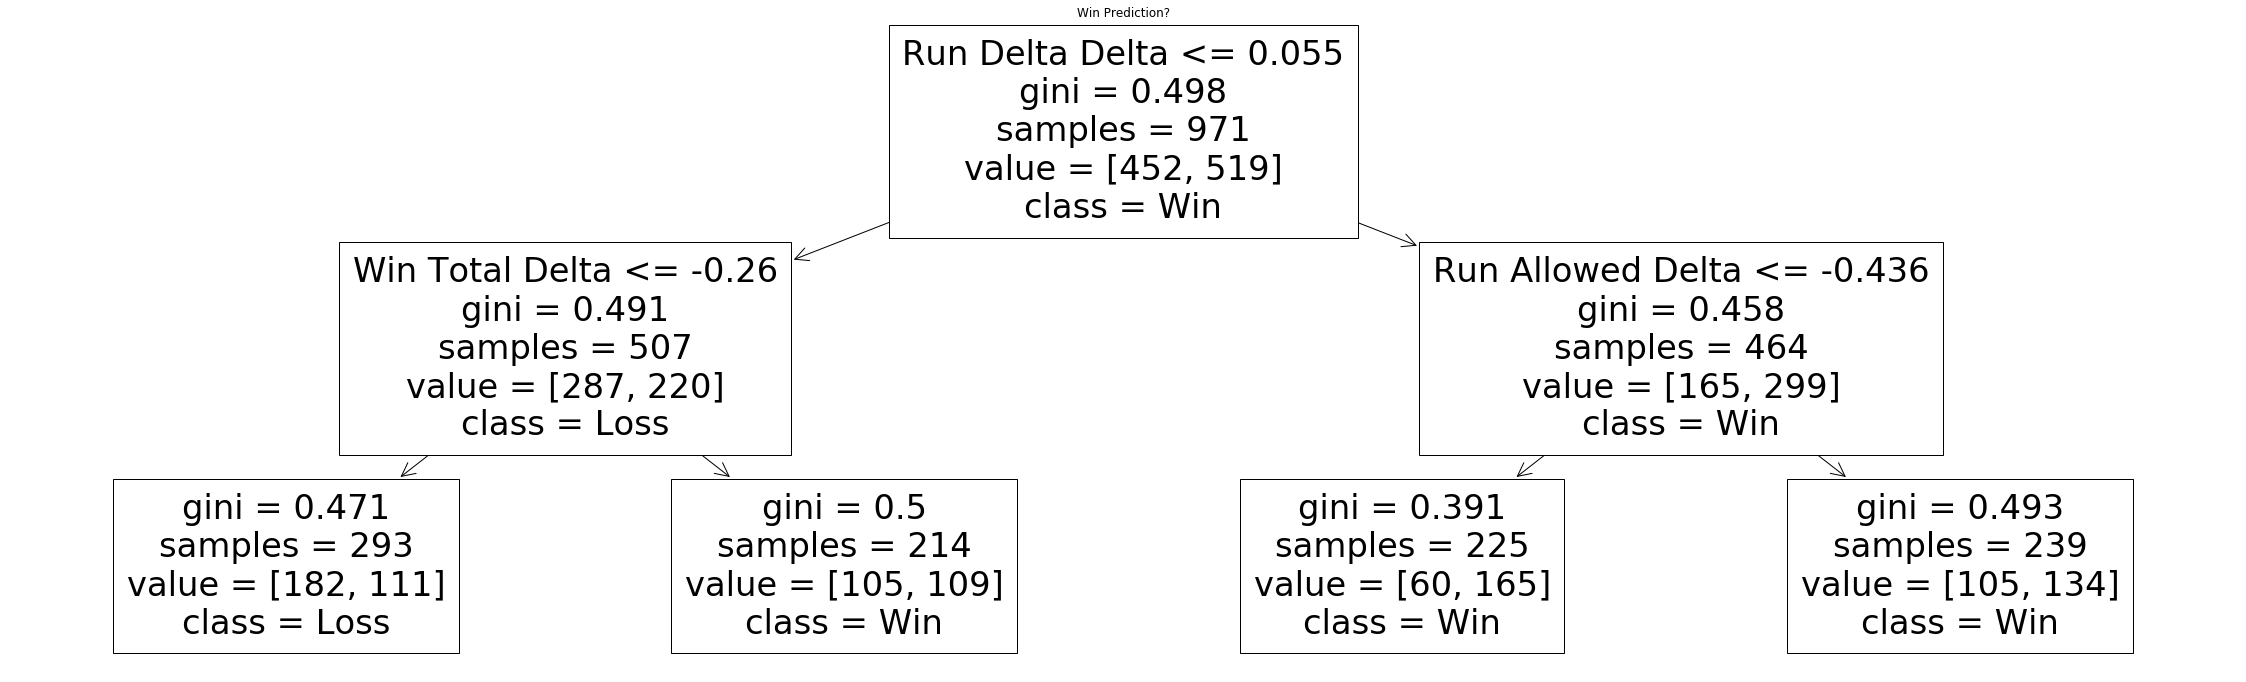

In [70]:
plt.figure(figsize=(40,12))
tree.plot_tree(clf, feature_names=df.columns[4:], class_names = ["Loss", "Win"])
#plt.savefig('gini_depth_7.pdf')
plt.title("Win Prediction?")
plt.show()

# Cross-Validation

In [71]:
scores = cross_val_score(estimator=clf,
                             X=X_transform,
                             y=y,
                             cv=10,
                             n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.57201646 0.61316872 0.57201646 0.52674897 0.55967078 0.58024691
 0.6090535  0.58436214 0.56790123 0.61570248]
CV accuracy: 0.580 +/- 0.026
